In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json

In [2]:
########load data from the first round #############
path = "/Users/wendy/Documents/DAI/first_round"
# change the working directory to the path where the data are located
os.chdir(path)
data_clean1 = pd.read_csv('data_clean_close.csv')
#change data type of transaction time to datetime
data_clean1['transaction_time'] = pd.to_datetime(data_clean1['transaction_time'])
#select the transaction data before '2021-07-01 00:00:00'
data_clean1 = data_clean1.loc[data_clean1['transaction_time']<'2021-07-01 00:00:00']

/Users/wendy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,9,13,14,15,16,22,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
#######load data from the second round ############
path = "/Users/wendy/Documents/DAI/second_round"
# change the working directory to the path where the data are located
os.chdir(path)
data_clean2 = pd.read_csv('data_clean_new.csv')
#change data type of transaction time to datetime
data_clean2['transaction_time'] = pd.to_datetime(data_clean2['transaction_time'])
#select the transaction data after '2021-07-01 00:00:00'
data_clean2 = data_clean2.loc[data_clean2['transaction_time']>='2021-07-01 00:00:00']
data_clean2 = data_clean2.reset_index(drop=True)

In [19]:
# Merge collection_slug
collection_10 = list(data_clean1['collection_slug_x'].drop_duplicates())
collection_slug_x = []
art_blocks_subcollection = []
for i in range(len(data_clean2)):
   if data_clean2.collection_slug_y[i] in collection_10:
      collection_slug_x.append(data_clean2.collection_slug_y[i])
      art_blocks_subcollection.append(0)
   else:
      collection_slug_x.append('art-blocks')
      art_blocks_subcollection.append(data_clean2.collection_slug_y[i])
data_clean2['collection_slug_x']=collection_slug_x
data_clean2['art_blocks_subcollection']=art_blocks_subcollection

In [20]:
########### Merge data form the first round and the second round ####################
data_clean = pd.concat([data_clean1,data_clean2])

In [6]:
data_clean.to_csv("/Users/wendy/Documents/DAI/second_round/data_clean_secondround.csv")

In [21]:
####### specifie data type of variables ###########
from datetime import datetime
#data_clean['auction_type'] = data_clean['auction_type'].astype('str')
#data_clean['collection_slug_x'] = data_clean['collection_slug_x'].astype('str')
#data_clean['event_type'] = data_clean['event_type'].astype('str')
#data_clean['id'] = data_clean['id'].astype('float').astype('int32')
#data_clean['payment_tocken'] = data_clean['payment_tocken'].astype('str')
#data_clean['asset_contract_type'] = data_clean['asset_contract_type'].astype('str')
#data_clean['name'] = data_clean['name'].astype('str')
#data_clean['description'] = data_clean['description'].astype('str')
#data_clean['asset_name'] = data_clean['asset_name'].astype('str')
#data_clean['num_sales'] = data_clean['num_sales'].astype('int')
data_clean['total_usd_price'] = data_clean['total_usd_price'].astype('float')
data_clean['transaction_time'] = pd.to_datetime(data_clean['transaction_time'])
data_clean['created_date_x'] = pd.to_datetime(data_clean['created_date_x'])

In [22]:
# drop useless columns
data_clean = data_clean.drop(columns = ['Unnamed: 0.1.1', 'collection_slug_y'])

In [23]:
###### preprocess 'auction_type' and 'traits'############
#fill na of 'auction_type' as 'english'
data_clean['auction_type'].fillna('english', inplace = True)
#create varaible 'trait_value' and 'trait_type' from 'traits' and strip the words as characteristics
import ast
trait_type = []
trait_value = []
for obj in data_clean['traits']:
    d= ast.literal_eval(obj)
    t_v = []
    t_t = []
    for trait in d:
        t_v.append(trait['value'])
        t_t.append(trait['trait_type'])
    trait_type.append(t_t)
    trait_value.append(t_v)
data_clean['trait_value']=trait_value
data_clean['trait_type']=trait_type

In [24]:
data_clean['contract_address'] = data_clean['contract_address.1'].fillna(data_clean['contract_address'])

###### (For UMAP colors, run this)###########
# get punk price
punk_data1= data_clean.sort_values(by=['transaction_time'])
punk_data = punk_data1[punk_data1['collection_slug']== 'cryptopunks']
punk_index_df = pd.read_csv('/Users/wendy/Documents/DAI/punk_index_df.csv')
s1 = pd.merge(punk_index_df, punk_data, how='left', on=['name'])
s2 = s1[s1.event_type=='successful']
s3 = s2.drop_duplicates(subset=['name'], keep='last')
s4 = s3[['name','total_price','total_usd_price','trait_type','trait_value']]
s5 = pd.merge(punk_index_df, s4, how='left', on=['name'])
s6 = s5.fillna(0)
s6.to_csv('/Users/wendy/Documents/GitHub/UMAP/punk_price.csv')

#get punk types
s7 = s1.drop_duplicates(subset=['name'], keep='last')
s8 = s7[['name','trait_type','trait_value']]
s9 = pd.merge(punk_index_df, s8, how='left', on=['name'])
s9[ s9.trait_value != s9.trait_value ]
s10 = s9.fillna(0)
cd = s10.trait_value.reset_index(drop = True)
ef = s10.trait_type.reset_index(drop = True)
call_1=[]
for i in range(len(s10)):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    if tr_t != 0:
        index1 = [index for index, x in enumerate(tr_t) if x == 'type']
        if bool(index1)!= False:
            call_1.append(tr_v[index1][0])
        else:
            call_1.append(0)
    else:
        call_1.append(0)
s10['punk_type']=call_1
s10.to_csv('/Users/wendy/Documents/GitHub/UMAP/punk_traits.csv')

In [25]:
###### Prepare data for Heckman correction ###########
import copy
#seperate 'successful', 'transfer', and 'cancelled' data 
data_clean_copy = copy.copy(data_clean)
data_clean_copy['Date'] = data_clean['transaction_time'].dt.to_period('h')
succ = data_clean_copy[data_clean_copy['event_type']=='successful'].reset_index()
tran = data_clean_copy[data_clean_copy['event_type']=='transfer'].reset_index()
canc = data_clean_copy[data_clean_copy['event_type']== 'cancelled'].reset_index()
#merge cancel and successful, cancel and transfer
canc_rem = canc.merge(succ, on= ['id','Date'], how='inner')['Unnamed: 0_x']
canc_rem1 = canc.merge(tran, on= ['id','Date'], how='inner')['Unnamed: 0_x']
#after each successful transaction is approved, one have to cancel it 
#so drop cancelled transaction wich is duplicated to successful ones, merge them
canc_left = canc[~canc['Unnamed: 0'].isin(canc_rem1)]
merge_d = succ.append(canc_left).reset_index()

In [26]:
######### create monthly and weekly time domain ########
data1 = merge_d
data_use = data1.sort_values(by=['transaction_time'])
data_use['month_year'] = data_use['transaction_time'].dt.to_period('M')
data_use['week'] = data_use['transaction_time'].dt.to_period('W')

In [27]:
######## now start to process the 'traits' ##########
u_assets = data_use.reset_index(drop=True)

In [28]:
########## aggregate num_to_account ###########
num_to_account=pd.DataFrame(u_assets.groupby(['to_account'])['id'].count().reset_index())
g1 = np.array(num_to_account[num_to_account.id>=1000].to_account)
g2 = np.array(num_to_account[num_to_account.id.between(100, 1000)].to_account)
g3 = np.array(num_to_account[num_to_account.id.between(2, 100)].to_account)
for i in range(len(u_assets['to_account'])):
    if u_assets['to_account'][i] in g1:
        u_assets['to_account'][i] = 'g1'
    elif u_assets['to_account'][i] in g2:
        u_assets['to_account'][i] = 'g2'
    elif u_assets['to_account'][i] in g3:
        u_assets['to_account'][i] = 'g3'
    else:
        u_assets['to_account'][i] = 'g4'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/wendy/anaconda3/lib/python3.7/site-packa

In [29]:
########## aggregate num_seller_address #########
num_seller_address=pd.DataFrame(u_assets.groupby(['seller_address'])['id'].count().reset_index())
g1 = np.array(num_seller_address[num_seller_address.id>=1000].seller_address)
g2 = np.array(num_seller_address[num_seller_address.id.between(500, 1000)].seller_address)
g3 = np.array(num_seller_address[num_seller_address.id.between(100, 500)].seller_address)
g4 = np.array(num_seller_address[num_seller_address.id.between(2, 100)].seller_address)
for i in range(len(u_assets['seller_address'])):
    if u_assets['seller_address'][i] in g1:
        u_assets['seller_address'][i] = 'g1'
    elif u_assets['seller_address'][i] in g2:
        u_assets['seller_address'][i] = 'g2'
    elif u_assets['seller_address'][i] in g3:
        u_assets['seller_address'][i] = 'g3'
    elif u_assets['seller_address'][i] in g4:
        u_assets['seller_address'][i] = 'g4'    
    else:
        u_assets['seller_address'][i] = 'g5'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/wendy/anaconda3/lib/pyt

In [30]:
########## aggregate num_winner_address ##########
num_winner_address=pd.DataFrame(u_assets.groupby(['winner_address'])['id'].count().reset_index())
g1 = np.array(num_winner_address[num_winner_address.id>=500].winner_address)
g2 = np.array(num_winner_address[num_winner_address.id.between(100, 500)].winner_address)
g3 = np.array(num_winner_address[num_winner_address.id.between(2, 100)].winner_address)
for i in range(len(u_assets['winner_address'])):
    if u_assets['winner_address'][i] in g1:
        u_assets['winner_address'][i] = 'g1'
    elif u_assets['winner_address'][i] in g2:
        u_assets['winner_address'][i] = 'g2'
    elif u_assets['winner_address'][i] in g3:
        u_assets['winner_address'][i] = 'g3'   
    else:
        u_assets['winner_address'][i] = 'g4'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/wendy/anaconda3/lib/python3.7/site-packa

In [31]:
########### aggregate num_owner_address ##########
num_owner_address=pd.DataFrame(u_assets.groupby(['owner_address'])['id'].count().reset_index())
g1 = np.array(num_owner_address[num_owner_address.id>=1000].owner_address)
g2 = np.array(num_owner_address[num_owner_address.id.between(500, 1000)].owner_address)
g3 = np.array(num_owner_address[num_owner_address.id.between(100, 500)].owner_address)
g4 = np.array(num_owner_address[num_owner_address.id.between(2, 100)].owner_address)
for i in range(len(u_assets['owner_address'])):
    if u_assets['owner_address'][i] in g1:
        u_assets['owner_address'][i] = 'g1'
    elif u_assets['owner_address'][i] in g2:
        u_assets['owner_address'][i] = 'g2'
    elif u_assets['owner_address'][i] in g3:
        u_assets['owner_address'][i] = 'g3'   
    elif u_assets['owner_address'][i] in g4:
        u_assets['owner_address'][i] = 'g4'
    else:
        u_assets['owner_address'][i] = 'g5'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/wendy/anac

In [32]:
########## aggregate num_creator_address ##############
num_creator_adress=pd.DataFrame(u_assets.groupby(['creator_adress'])['id'].count().reset_index())
g1 = np.array(num_creator_adress[num_creator_adress.id>=2000].creator_adress)
g2 = np.array(num_creator_adress[num_creator_adress.id.between(1000, 2000)].creator_adress)
g3 = np.array(num_creator_adress[num_creator_adress.id.between(100, 1000)].creator_adress)
g4 = np.array(num_creator_adress[num_creator_adress.id.between(2, 100)].creator_adress)
for i in range(len(u_assets['creator_adress'])):
    if u_assets['creator_adress'][i] in g1:
        u_assets['creator_adress'][i] = 'g1'
    elif u_assets['creator_adress'][i] in g2:
        u_assets['creator_adress'][i] = 'g2'
    elif u_assets['creator_adress'][i] in g3:
        u_assets['creator_adress'][i] = 'g3'   
    elif u_assets['creator_adress'][i] in g4:
        u_assets['creator_adress'][i] = 'g4'
    else:
        u_assets['creator_adress'][i] = 'g5'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/wendy/anac

In [33]:
u_assets.columns

Index(['level_0', 'index', 'Unnamed: 0', 'Unnamed: 0.1', 'auction_type',
       'collection_slug_x', 'created_date_x', 'event_type', 'id',
       'total_price', 'payment_tocken', 'token_usd_price', 'to_account',
       'transaction_time', 'seller_address', 'seller_account',
       'winner_address', 'winner_account', 'image_url', 'image_preview_url',
       'contract_address', 'image_thumbnail_url', 'image_original_url',
       'external_link', 'asset_contract_type', 'num_sales', 'name',
       'description', 'asset_name', 'schema_name', 'owner_address',
       'creator_adress', 'traits', 'trait_type', 'trait_value',
       'total_usd_price', 'created_date_y', 'contract_address.1',
       'art_blocks_section', 'art_blocks_subcollection', 'Date', 'month_year',
       'week'],
      dtype='object')

In [34]:
######### extract traits from each collections #########
u_assets['autoglyphs_trait_v']=0
cd=u_assets[u_assets['collection_slug_x']=='autoglyphs'].trait_value
ef =[] 
for item in cd:
    ef.append(item[0])
u_assets.loc[u_assets['collection_slug_x']=='autoglyphs','autoglyphs_trait_v']=ef

In [35]:
u_assets['art-blocks_trait_v']=0
cd =u_assets[u_assets['collection_slug_x']=='art-blocks'].trait_value
ef =[] 
for item in cd:
    if item != []:
        ef.append(item[0])
    else:
        ef.append([])
u_assets.loc[u_assets['collection_slug_x']=='art-blocks','art-blocks_trait_v']=ef

/Users/wendy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/wendy/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:711: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/Users/wendy/anaconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py:866: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

In [36]:
new_sub = u_assets[u_assets['collection_slug_x']=='art-blocks']['art_blocks_subcollection'].fillna(u_assets['art-blocks_trait_v'])
u_assets.loc[u_assets['collection_slug_x']=='art-blocks','art_blocks_subcollection'] = new_sub

In [37]:
import itertools
ab = list(itertools.chain.from_iterable(u_assets[u_assets['collection_slug_x']=='boredapeyachtclub'].trait_type))
#count_trait_type=[[x,ab.count(x)] for x in set(ab)]
from collections import Counter
con = list(Counter(ab))

In [38]:
u_assets['bdap_Background']=0
u_assets['bdap_Earring']=0
u_assets['bdap_Fur']=0
u_assets['bdap_Hat']=0
u_assets['bdap_Eyes']=0
u_assets['bdap_Clothes']=0
u_assets['bdap_Mouth']=0
cd =u_assets[u_assets['collection_slug_x']=='boredapeyachtclub'].trait_value.reset_index(drop = True)
ef =u_assets[u_assets['collection_slug_x']=='boredapeyachtclub'].trait_type.reset_index(drop = True)
call_1=[]
call_2=[]
call_3=[]
call_4=[]
call_5=[]
call_6=[]
call_7=[]
for i in range(len(cd)):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    index1 = [index for index, x in enumerate(tr_t) if x == 'Background']
    index2 = [index for index, x in enumerate(tr_t) if x == 'Earring']
    index3 = [index for index, x in enumerate(tr_t) if x == 'Fur']
    index4 = [index for index, x in enumerate(tr_t) if x == 'Hat']
    index5 = [index for index, x in enumerate(tr_t) if x == 'Eyes']
    index6 = [index for index, x in enumerate(tr_t) if x == 'Clothes']
    index7 = [index for index, x in enumerate(tr_t) if x == 'Mouth']
    if bool(index1)!= False:
        call_1.append(tr_v[index1][0])
    else:
        call_1.append(0)
    if bool(index2)!= False:
        call_2.append(tr_v[index2][0])
    else:
        call_2.append(0)
    if bool(index3)!= False:
        call_3.append(tr_v[index3][0])
    else:
        call_3.append(0)
    if bool(index4)!= False:
        call_4.append(tr_v[index4][0])
    else:
        call_4.append(0)
    if bool(index5)!= False:
        call_5.append(tr_v[index5][0])
    else:
        call_5.append(0)
    if bool(index6)!= False:
        call_6.append(tr_v[index6][0])
    else:
        call_6.append(0)
    if bool(index7)!= False:
        call_7.append(tr_v[index7][0])
    else:
        call_7.append(0)

In [39]:
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Background']=call_1
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Earring']=call_2
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Fur']=call_3
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Hat']=call_4
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Eyes']=call_5
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Clothes']=call_6
u_assets.loc[u_assets['collection_slug_x']=='boredapeyachtclub','bdap_Mouth']=call_7

In [40]:
ab = list(itertools.chain.from_iterable(u_assets[u_assets['collection_slug_x']=='hashmasks'].trait_type))
#count_trait_type=[[x,ab.count(x)] for x in set(ab)]
from collections import Counter
Counter(ab)
con = list(Counter(ab))

In [41]:
u_assets['hash_Item']=0
u_assets['hash_Mask']=0
u_assets['hash_Character']=0
u_assets['hash_Skin Color']=0
u_assets['hash_Eye Color']=0
u_assets['hash_Background']=0
u_assets['hash_Glyph']=0
u_assets['hash_Set']=0
cd =u_assets[u_assets['collection_slug_x']=='hashmasks'].trait_value.reset_index(drop = True)
ef =u_assets[u_assets['collection_slug_x']=='hashmasks'].trait_type.reset_index(drop = True)
call_1=[]
call_2=[]
call_3=[]
call_4=[]
call_5=[]
call_6=[]
call_7=[]
call_8=[]
for i in range(len(cd)):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    index1 = [index for index, x in enumerate(tr_t) if x == 'Item']
    index2 = [index for index, x in enumerate(tr_t) if x == 'Mask']
    index3 = [index for index, x in enumerate(tr_t) if x == 'Character']
    index4 = [index for index, x in enumerate(tr_t) if x == 'Skin Color']
    index5 = [index for index, x in enumerate(tr_t) if x == 'Eye Color']
    index6 = [index for index, x in enumerate(tr_t) if x == 'Background']
    index7 = [index for index, x in enumerate(tr_t) if x == 'Glyph']
    index8 = [index for index, x in enumerate(tr_t) if x == 'Set']
    if bool(index1)!= False:
        call_1.append(tr_v[index1][0])
    else:
        call_1.append(0)
    if bool(index2)!= False:
        call_2.append(tr_v[index2][0])
    else:
        call_2.append(0)
    if bool(index3)!= False:
        call_3.append(tr_v[index3][0])
    else:
        call_3.append(0)
    if bool(index4)!= False:
        call_4.append(tr_v[index4][0])
    else:
        call_4.append(0)
    if bool(index5)!= False:
        call_5.append(tr_v[index5][0])
    else:
        call_5.append(0)
    if bool(index6)!= False:
        call_6.append(tr_v[index6][0])
    else:
        call_6.append(0)
    if bool(index7)!= False:
        call_7.append(tr_v[index7][0])
    else:
        call_7.append(0)
    if bool(index8)!= False:
        call_8.append(tr_v[index8][0])
    else:
        call_8.append(0)

In [42]:
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Item']=call_1
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Mask']=call_2
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Character']=call_3
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Skin Color']=call_4
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Eye Color']=call_5
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Background']=call_6
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Glyph']=call_7
u_assets.loc[u_assets['collection_slug_x']=='hashmasks','hash_Set']=call_8

In [43]:
ab = list(itertools.chain.from_iterable(u_assets[u_assets['collection_slug_x']=='makersplace'].trait_type))
#count_trait_type=[[x,ab.count(x)] for x in set(ab)]
from collections import Counter
Counter(ab)

Counter({'Creator': 20281})

In [44]:
u_assets['creators']=0
cd=u_assets[u_assets['collection_slug_x']=='makersplace'].trait_value
ef =[] 
for item in cd:
    if bool(item)!= False:
        ef.append(item[0])
    else:
        ef.append(0)
u_assets.loc[u_assets['collection_slug_x']=='makersplace','creators']=ef

In [45]:
ab = list(itertools.chain.from_iterable(u_assets[u_assets['collection_slug_x']=='superrare'].trait_type))
#count_trait_type=[[x,ab.count(x)] for x in set(ab)]
from collections import Counter
Counter(ab)

Counter({'tag': 94799, 'year_created': 11487, 'artist': 11490})

In [46]:
u_assets['super_tag']=0
u_assets['super_year_created']=0
cd =u_assets[u_assets['collection_slug_x']=='superrare'].trait_value.reset_index(drop = True)
ef =u_assets[u_assets['collection_slug_x']=='superrare'].trait_type.reset_index(drop = True)
call_1=[]
call_2=[]
call_3=[]
for i in range(len(cd)):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    index1 = [index for index, x in enumerate(tr_t) if x == 'tag']
    index2 = [index for index, x in enumerate(tr_t) if x == 'year_created']
    index3 = [index for index, x in enumerate(tr_t) if x == 'artist']
    if bool(index1)!= False:
        call_1.append(tr_v[index1])
    else:
        call_1.append('0')
    if bool(index2)!= False:
        call_2.append(tr_v[index2][0])
    else:
        call_2.append(0)
    if bool(index3)!= False:
        call_3.append(tr_v[index3][0])
    else:
        call_3.append(0)

u_assets.loc[u_assets['collection_slug_x']=='superrare','creators']=call_3
u_assets.loc[u_assets['collection_slug_x']=='superrare','super_tag']=call_1
u_assets.loc[u_assets['collection_slug_x']=='superrare','super_year_created']=call_2

In [47]:
import re
import string
from nltk.corpus import stopwords 
super_tag = u_assets.loc[u_assets['collection_slug_x']=='superrare','super_tag']
#join words as corpus
tag1 = super_tag.apply(lambda x:' '.join(x))
#convert to lowercase
tag2 = tag1.apply(lambda x: x.lower())
#Expand contractions
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}
#Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
tag3 = tag2.apply(lambda x:expand_contractions(x))
#remove punctuation
tag4 = tag3.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
#remove digits
tag5 = tag4.apply(lambda x: re.sub(r'\w*\d\w*', '', x))
#remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
tag6 = tag5.apply(lambda x: remove_stopwords(x))
#remove extra spaces
tag7 = tag6.apply(lambda x: re.sub(' +', ' ', x))
#split the tags again
tag8 = tag7.apply(lambda x: x.split())
u_assets.loc[u_assets['collection_slug_x']=='superrare','super_tag'] = tag8

In [48]:
x_tr = list(itertools.chain.from_iterable(tag8))
x_uni = list(set(x_tr))

# load GloVe
embeddings_index = dict()
f = open('../glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

#create embedding matrix for super_tags
embedding_matrix = np.zeros((len(x_uni), 50))
for i in range(len(x_uni)):
    embedding_vector = embeddings_index.get(x_uni[i])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#create dictionary matching words and vectors
glove_dict = {}
for i in range(len(x_uni)):
    glove_dict[x_uni[i]] = embedding_matrix[i]

#create glove index for each super_tag
call = u_assets.loc[u_assets['collection_slug_x']=='superrare'].super_tag.reset_index(drop=True)
glove_ls = np.zeros((len(call), 50))
for i in range(len(call)):
    ls = call.iloc[i]
    ls_new = [1/len(ls)* glove_dict[item] for item in ls]
    glove_index = np.array(np.sum(i for i in ls_new))
    glove_ls[i,]= glove_index

Loaded 400000 word vectors.


/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [49]:
import sklearn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(glove_ls)
labels = kmeans.labels_

In [50]:
u_assets['super_tag_cluster']=0
u_assets.loc[u_assets['collection_slug_x']=='superrare','super_tag_cluster']= labels.tolist()

from sklearn.decomposition import PCA
X1pca = PCA(n_components=2).fit_transform(embedding_matrix)

import umap.umap_ as umap
X2umap = umap.UMAP(random_state=123, n_neighbors=10, min_dist =0.1).fit_transform(embedding_matrix)


def plot_word_emb(reducer,method):
    plt.rcParams['figure.figsize'] = (30,30)
    fig, ax = plt.subplots()

    for word, x1, x2 in zip(x_tr, reducer[:,0], reducer[:,1]):
        ax.annotate(word, (x1,x2 ))
        
    PADDING = 1.0
    x_axis_min = np.amin(reducer, axis=0)[0] - PADDING
    y_axis_min = np.amin(reducer, axis=0)[1] - PADDING
    x_axis_max = np.amax(reducer, axis=0)[0] + PADDING
    y_axis_max = np.amax(reducer, axis=0)[1] + PADDING
    
    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    #plt.rcParams["figure.figsize"] = (10,10)

    plt.savefig(f'text_{method}.png', transparent=True)

plot_word_emb(X2umap, method = 'umap')

plot_word_emb(X1pca, method = 'pca')

In [51]:
num_creators=pd.DataFrame(u_assets.groupby(['creators'])['id'].count().reset_index())
g1 = np.array(num_creators[num_creators.id>=1000].creators)
g2 = np.array(num_creators[num_creators.id.between(100, 1000)].creators)
g3 = np.array(num_creators[num_creators.id.between(2, 100)].creators)
for i in range(len(u_assets['creators'])):
    if u_assets['creators'][i] in g1:
        u_assets['creators'][i] = 'g1'
    elif u_assets['creators'][i] in g2:
        u_assets['creators'][i] = 'g2'
    elif u_assets['creators'][i] in g3:
        u_assets['creators'][i] = 'g3'   
    else:
        u_assets['creators'][i] = 'g4'

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __

In [52]:
num_hash_SkinColor = pd.DataFrame(u_assets.groupby(['hash_Skin Color'])['id'].count().reset_index())
others = np.array(num_hash_SkinColor[num_hash_SkinColor.id<135]['hash_Skin Color'])
for i in range(len(u_assets['hash_Skin Color'])):
    if u_assets['creators'][i] in others:
        u_assets['creators'][i] = 'others'

In [53]:
u_assets['punk_type']=0
u_assets['punk_accessory']=0
cd = u_assets[u_assets['collection_slug_x']=='cryptopunks'].trait_value.reset_index(drop = True)
ef = u_assets[u_assets['collection_slug_x']=='cryptopunks'].trait_type.reset_index(drop = True)
call_1=[]
call_2=[]
for i in range(len(u_assets[u_assets['collection_slug_x']=='cryptopunks'])):
    tr_v = np.array(cd[i])
    tr_t = ef[i]
    if tr_t != 0:
        index1 = [index for index, x in enumerate(tr_t) if x == 'type']
        index2 = [index for index, x in enumerate(tr_t) if x == 'accessory']
        if bool(index1)!= False:
            call_1.append(tr_v[index1][0])
        else:
            call_1.append(['no type'])
        if bool(index2)!= False:
            call_2.append(tr_v[index2].tolist())
        else:
            call_2.append(['no accessory'])
    else:
        call_1.append(0)
        call_2.append(0)
u_assets.loc[u_assets['collection_slug_x']=='cryptopunks','punk_type']=call_1
u_assets.loc[u_assets['collection_slug_x']=='cryptopunks','punk_accessory']=call_2

/Users/wendy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/wendy/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:711: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/Users/wendy/anaconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py:866: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

In [54]:
#calculate TF-IDF of punk_accessory
con_str = u_assets.loc[u_assets['collection_slug_x']=='cryptopunks'].drop_duplicates(subset='id').punk_accessory
ab = list(itertools.chain.from_iterable(con_str))
from collections import Counter
conter_dict = Counter(ab)
conter_dict.update({'6 attributes': 0})
keys = list(conter_dict.keys())
values = list(conter_dict.values())
sum= np.array(values)
idf = len(con_str)/np.log(sum+1)
idf[-5:]=0

#create idf dictionary
idf_dict = {}
for i in range(len(keys)):
    idf_dict[keys[i]] = idf[i]

#create tf-idf index for each asset
index_ls = []
call = u_assets.loc[u_assets['collection_slug_x']=='cryptopunks'].punk_accessory
for ls in call:
    tfidf_index = np.array([1/len(ls)*idf_dict[item] for item in ls]).sum()
    index_ls.append(tfidf_index)
u_assets.loc[u_assets['collection_slug_x']=='cryptopunks','punk_accessory']=index_ls

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [529]:
u_assets.to_csv('/Users/wendy/Documents/DAI/u_assets.csv')

In [3]:
u_assets = pd.read_csv('/Users/wendy/Documents/DAI/u_assets.csv')
u_assets = u_assets.drop(columns = ['Unnamed: 0.1.1'])

/Users/wendy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,37,38,39,40,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
create_date_prep = u_assets['created_date_x'].fillna(u_assets['created_date_y'])
u_assets['created_year'] = pd.to_datetime(create_date_prep).dt.to_period('Y')

In [5]:
crix_data = pd.read_csv('/Users/wendy/Documents/DAI/new_crix.csv')
crix = crix_data[crix_data.date>='2019-03-20']
crix['date'] = pd.to_datetime(crix['date'])
crix['week'] = crix['date'].dt.to_period('W')
weekly_median_crix = crix.groupby(['week']).median()
weekly_median_crix = weekly_median_crix.reset_index()
weekly_median_crix.columns =['week','crix']
u_assets.week= u_assets.week.astype(str)
weekly_median_crix.week= weekly_median_crix.week.astype(str)
u_assets1 = u_assets.merge(weekly_median_crix, how = 'left', on = ['week'])

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.



pd.DataFrame(u_assets[u_assets.collection_slug_x=='beeple-everydays']['id'].reset_index(drop=True)).astype('int').to_csv('id_beeple-everydays.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='cryptopunks']['id'].reset_index(drop=True)).astype('int').to_csv('id_cryptopunks.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='makersplace']['id'].reset_index(drop=True)).astype('int').to_csv('id_makersplace.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='rarible']['id'].reset_index(drop=True)).astype('int').to_csv('id_rarible.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='superrare']['id'].reset_index(drop=True)).astype('int').to_csv('id_superrare.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='hashmasks']['id'].reset_index(drop=True)).astype('int').to_csv('id_hashmasks.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='autoglyphs']['id'].reset_index(drop=True)).astype('int').to_csv('id_autoglyphs.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='boredapeyachtclub']['id'].reset_index(drop=True)).astype('int').to_csv('id_sboredapeyachtclub.csv')
pd.DataFrame(u_assets[u_assets.collection_slug_x=='art-blocks']['id'].reset_index(drop=True)).astype('int').to_csv('id_art-blocks.csv')


In [6]:
data_tr= u_assets1.drop(columns = ['level_0', 'index', 'Unnamed: 0', 'Unnamed: 0.1','created_date_x','created_date_y','id', 'transaction_time','Date',
'seller_account','winner_account','image_url','image_preview_url','image_thumbnail_url','image_original_url','external_link','name',
'description','asset_name','total_price','token_usd_price','total_usd_price','traits', 'trait_type','trait_value','super_tag', 'super_year_created',
'hash_Set','month_year','art-blocks_trait_v','contract_address.1'])

In [7]:
data_tr['total_price'] = u_assets1['total_price']
data_tr1 = data_tr.drop(columns = ['num_sales','total_price','punk_accessory','crix'])


#### If need transaction time #########
data_tr['transaction_time'] = u_assets['transaction_time']
data_tr1 = data_tr[data_tr.total_price.isna()==False]
transaction_time = data_tr1['transaction_time']
transaction_time.to_csv('/home/fabian/BW_codes/Second_round/transaction_time.csv')

In [8]:
data_tr2 = data_tr1.astype('str')

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='first', sparse=False)
onehot= enc.fit_transform(data_tr2)
#print(onehot)


In [76]:
#enc1 = OneHotEncoder(sparse=False)
#onehot1= enc1.fit_transform(data_tr2)
#ols_coeff_df = pd.DataFrame({'X_ols': enc1.get_feature_names_out()})
#ols_coeff_df.to_csv('/Users/wendy/Documents/DAI/ols_coeff_df.csv')

In [254]:
data_tr2.columns

Index(['auction_type', 'collection_slug_x', 'event_type', 'payment_tocken',
       'to_account', 'seller_address', 'winner_address', 'contract_address',
       'asset_contract_type', 'schema_name', 'owner_address', 'creator_adress',
       'art_blocks_section', 'art_blocks_subcollection', 'week',
       'autoglyphs_trait_v', 'bdap_Background', 'bdap_Earring', 'bdap_Fur',
       'bdap_Hat', 'bdap_Eyes', 'bdap_Clothes', 'bdap_Mouth', 'hash_Item',
       'hash_Mask', 'hash_Character', 'hash_Skin Color', 'hash_Eye Color',
       'hash_Background', 'hash_Glyph', 'creators', 'super_tag_cluster',
       'punk_type', 'created_year'],
      dtype='object')

In [255]:
X_df_all = pd.DataFrame(onehot,columns = enc.get_feature_names())
X_df_all['num_sales'] = np.array(data_tr['num_sales'])
X_df_all['punk_accessory'] = np.array(data_tr['punk_accessory'])
#X_df_all['crix'] = np.array(data_tr['crix'])
y_df_all = data_tr['total_price']
sum_df = X_df_all.sum(axis = 0)
x_drop = sum_df.loc[sum_df==1].index
X_df_all = X_df_all.drop(columns = x_drop)

#check multicolinearity
corr_X = X_df_all.corr()
for i in range(len(corr_X)):
    corr_X.iloc[i,i]=0
    
cor_df= pd.DataFrame(corr_X)
[(indexs,i) for indexs in cor_df.index for i in range(len(cor_df)) if(cor_df.loc[indexs].values[i] ==1)] 

In [256]:
rem_col=['x7_0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb','x7_0x7f268357a8c2552623316e2562d90e642bb538e5', 'x3_nan','x20_Zombie',
'x9_ERC1155','x7_0x41a322b28d0ff354040e2cbc676f0320d8c8850d','x26_Gold','x27_Mystical','x26_Mystical','x26_Wood','x27_Painted','x26_Steel','x3_nan',
'x7_0x7f268357a8c2552623316e2562d90e642bb538e5','x13_nan', 'x12_nan']
X_df_all_new = X_df_all.drop(columns = rem_col)

In [257]:
X_df_all_new.to_csv('/Users/wendy/Documents/DAI/second_round/X_df_all.csv')
y_df_all.to_csv('/Users/wendy/Documents/DAI/second_round/y_df_all.csv')

# start from here

In [258]:
#if need to load from file
X_df_all_new = pd.read_csv('/Users/wendy/Documents/DAI/second_round/X_df_all.csv')
y_df_all= pd.read_csv('/Users/wendy/Documents/DAI/second_round/y_df_all.csv')
X_df_new = X_df_all_new.drop(columns = ['Unnamed: 0'])
X = X_df_new.values
y_df_all1 = y_df_all.total_price
y_df_all1[y_df_all1.isna()==True]=0
y_df_all1[y_df_all1!= 0]= np.log(y_df_all1[y_df_all1 != 0])
y = y_df_all1.values

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [259]:
y_df_all1.to_csv('/Users/wendy/Documents/DAI/y_df.csv')
X_df_new.to_csv('/Users/wendy/Documents/DAI/X_df.csv')

In [271]:
import copy
select_data = copy.copy(X_df_new)
select_data['price']= y
select_data['transaction_date']=pd.to_datetime(u_assets['transaction_time']).dt.to_period('D')
select_data['transaction_week']=u_assets['week']
select_data1 = select_data[select_data['price']!=0]
select_y = select_data1['price'].values
select_data2 = select_data1.drop(columns = ['price','transaction_week','transaction_date'])
select_X = select_data2.values

In [274]:
# heckman correction (probit model)
from statsmodels.discrete.discrete_model import Probit
probit_y = select_data['price']!=0
# select X included in probit model
H_X = X_df_new.drop(columns = X_df_new.iloc[:,84:239])
X1 = H_X.iloc[:,:84].values
model = Probit(probit_y, X1)
probit_model = model.fit()
print(probit_model.summary())

         Current function value: 0.153336
         Iterations: 35


/Users/wendy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                          Probit Regression Results                           
Dep. Variable:                  price   No. Observations:               162563
Model:                         Probit   Df Residuals:                   162479
Method:                           MLE   Df Model:                           83
Date:                Mon, 05 Sep 2022   Pseudo R-squ.:                  0.5483
Time:                        11:24:01   Log-Likelihood:                -24927.
converged:                      False   LL-Null:                       -55186.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.9052   1141.742      0.006      0.995   -2230.867    2244.678
x2             3.7766   1162.711      0.003      0.997   -2275.096    2282.649
x3            -0.5283      0.103     -5.117      0.0

In [275]:
#heckman correction (inverse mills ratio)
from scipy.stats import norm
probit_lp = probit_model.predict(X1)
mills0 = norm.pdf(probit_lp)/norm.cdf(probit_lp)
imr = mills0[probit_y]
select_data3 = copy.copy(select_data2)
select_data3['imr'] = imr
correct_X = select_data3.values

In [276]:
#OLS model on truncated data
import statsmodels.api as sm
mod = sm.OLS(select_y, select_X)
reg0 = mod.fit()
coeff_a = reg0.params
print(reg0.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     907.6
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:24:53   Log-Likelihood:            -2.3054e+05
No. Observations:              145224   AIC:                         4.621e+05
Df Residuals:                  144728   BIC:                         4.670e+05
Df Model:                         495                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0337      0.699     -0.048      0.9

In [277]:
#corrected model
mod = sm.OLS(select_y, correct_X)
reg = mod.fit()
h_coef = reg.params
heckman_coef = pd.DataFrame(h_coef)
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     908.0
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:25:27   Log-Likelihood:            -2.3040e+05
No. Observations:              145224   AIC:                         4.618e+05
Df Residuals:                  144727   BIC:                         4.667e+05
Df Model:                         496                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0055      0.701      1.434      0.1

heckman_coef = pd.read_csv('/Users/wendy/Documents/DAI/heckman_coef.csv')
heckman_data = pd.read_csv('/Users/wendy/Documents/DAI/heckman_data.csv')

In [283]:
heckman_est_y = np.dot(correct_X,heckman_coef.iloc[:,0])
heckman_res = y[y!=0]- heckman_est_y

In [284]:
def psi_fun(x, kappa_upper, kappa_lower):
    if abs(x)<= kappa_upper and abs(x) >= kappa_lower:
        y= x
    elif x< kappa_lower:
        y= kappa_lower
    else:
        y= kappa_upper
    return(y)

In [285]:
kappa_09_heckman = np.quantile(heckman_res,0.9)
kappa_01_heckman = np.quantile(heckman_res,0.1)
kappa_095_heckman = np.quantile(heckman_res,0.95)
kappa_005_heckman = np.quantile(heckman_res,0.05)
kappa_07_heckman = np.quantile(heckman_res,0.7)
kappa_025_heckman = np.quantile(heckman_res,0.25)
kappa_09_ols = np.quantile(reg0.resid,0.9)
kappa_01_ols = np.quantile(reg0.resid,0.1)
kappa_095_ols = np.quantile(reg0.resid,0.95)
kappa_005_ols = np.quantile(reg0.resid,0.05)
kappa_07_ols = np.quantile(reg0.resid,0.7)
kappa_025_ols = np.quantile(reg0.resid,0.25)

In [286]:
deno_heckman = np.array([item >kappa_005_heckman and item <kappa_095_heckman for item in heckman_res]).sum()
deno_OLS = np.array([item >kappa_005_ols and item <kappa_095_ols for item in reg0.resid]).sum()
huber_trans_Heckmanres= [psi_fun(item,kappa_upper=kappa_095_heckman, kappa_lower=kappa_005_heckman) for item in heckman_res]
huber_trans_OLSres= [psi_fun(item,kappa_upper=kappa_095_ols, kappa_lower=kappa_005_ols) for item in reg0.resid]
huber_Heckmanres = np.array(huber_trans_Heckmanres)*len(heckman_res)/deno_heckman
huber_OLSres = np.array(huber_trans_OLSres)*len(reg0.resid)/deno_OLS
huber_yHeckman = heckman_est_y +huber_trans_Heckmanres
huber_yOLS = reg0.predict(select_X) +huber_OLSres

In [84]:
pd.DataFrame(huber_yHeckman).to_csv('/Users/wendy/Documents/DAI/second_round/huber_yHeckman.csv')
pd.DataFrame(huber_yOLS).to_csv('/Users/wendy/Documents/DAI/second_round/huber_yOLS.csv')

In [287]:
import statsmodels.api as sm
mod = sm.OLS(huber_yOLS, select_X)

Huber_reg = mod.fit()

huber_OLScoeff = Huber_reg.params
print(Huber_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1243.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:28:47   Log-Likelihood:            -2.0870e+05
No. Observations:              145224   AIC:                         4.184e+05
Df Residuals:                  144728   BIC:                         4.233e+05
Df Model:                         495                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0591      0.601      0.098      0.9

In [288]:
mod = sm.OLS(huber_yHeckman, correct_X)
Huber_Heckman_reg = mod.fit()
huber_Heckman_coeff = Huber_Heckman_reg.params
print(Huber_Heckman_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1530.
Date:                Mon, 05 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:29:08   Log-Likelihood:            -1.9342e+05
No. Observations:              145224   AIC:                         3.878e+05
Df Residuals:                  144727   BIC:                         3.928e+05
Df Model:                         496                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8409      0.544      1.547      0.1

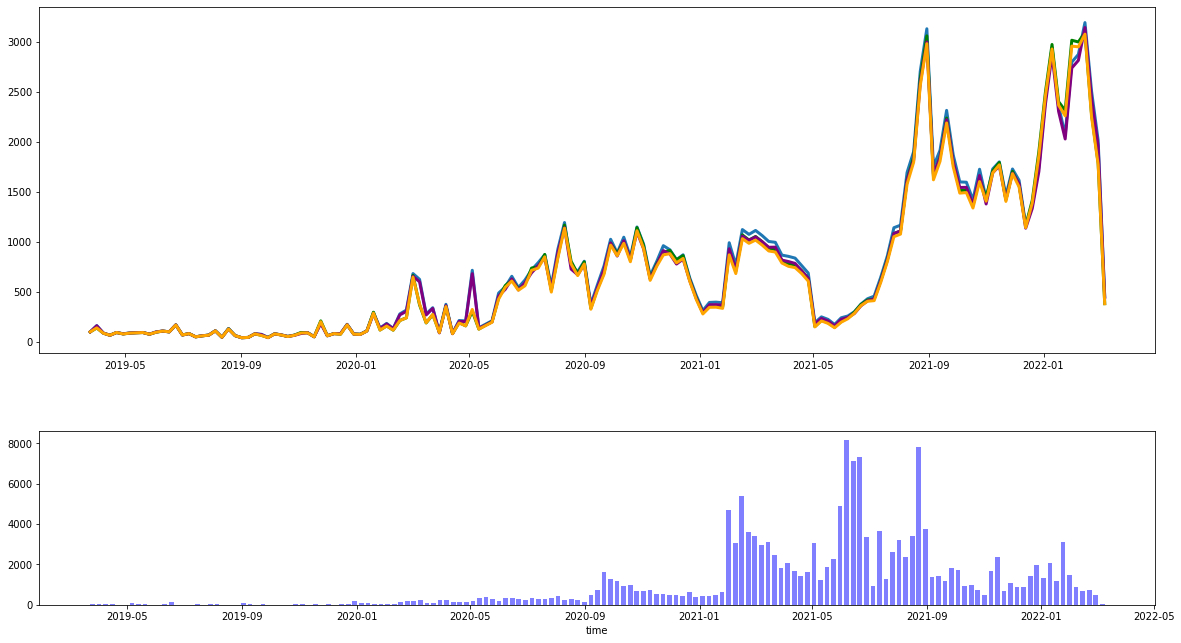

In [295]:
xx = X_df_new.columns[84:239]
xx = xx.str.replace('x14_', '', regex=True)
xx = xx.str.slice(start=0,stop=10)
xx = pd.to_datetime(xx)
import math
beta = coeff_a[84:239]
beta1 = huber_OLScoeff[84:239]
beta2 = heckman_coef[84:239].iloc[:,0].reset_index(drop=True)
beta3 = huber_Heckman_coeff[84:239]
beta_re = beta-beta[0]
beta_re1 = beta1-beta1[0]
beta_re2 = beta2-beta2[0]
beta_re3 = beta3-beta3[0]
beta_plot = [100*math.exp(item) for item in beta_re]
beta_plot1 = [100*math.exp(item) for item in beta_re1]
beta_plot2 = [100*math.exp(item) for item in beta_re2]
beta_plot3 = [100*math.exp(item) for item in beta_re3]

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,11), gridspec_kw={'height_ratios': [2, 1]})
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.3)
ax1.plot(xx, beta_plot, linewidth=3)#"--"
ax1.plot(xx, beta_plot1,color='green',linewidth=3)
ax1.plot(xx, beta_plot2,color='purple',linewidth=3)
ax1.plot(xx, beta_plot3,color='orange',linewidth=3)

weekly_transactions = select_data.groupby(['transaction_week']).count()['x0_english'].reset_index(['transaction_week'])
number_transactions = weekly_transactions['x0_english'][1:]
rects1 = ax2.bar(xx, number_transactions, width=5, align ='center',color='blue', alpha=0.5 )
ax2.set_xlabel('time')

plt.savefig('/Users/wendy/Documents/DAI/ETH_meanreg_expbeta_compare.pdf',transparent=True)

In [291]:
residual_dt = pd.DataFrame()
residual_dt['transaction_date']= select_data1['transaction_date']
residual_dt['transaction_week']= select_data1['transaction_week']
residual_dt['residual_heckman']= heckman_res
residual_dt['residual_ols']=reg0.resid
residual_dt['Huber_residual_heckman'] = Huber_Heckman_reg.resid
residual_dt['Huber_residual_ols']= Huber_reg.resid
residual_dt['transaction_date']= residual_dt['transaction_date'].dt.to_timestamp('d').dt.strftime('%Y-%m-%d')
#residual_dt.to_csv('/Users/wendy/Documents/DAI/residual_df.csv')

In [296]:
beta_dt1 = pd.DataFrame(weekly_transactions['transaction_week'])
beta_dt = beta_dt1.iloc[1:]
beta_dt['beta'] = huber_Heckman_coeff[84:239]
beta_dt.to_csv('/Users/wendy/Documents/DAI/beta_dt.csv')

/Users/wendy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [297]:
residual_dt = pd.read_csv('/Users/wendy/Documents/DAI/residual_df.csv')
plot_df =residual_dt.sort_values(by='transaction_date')
mean_df = plot_df.groupby([plot_df['transaction_date']], as_index=False).mean()
count_df = plot_df.groupby([plot_df['transaction_date']], as_index=False).count()

In [210]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import time
import datetime
import logging

In [114]:

fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0)

fig['layout'].update(height=800, width=1600,
                    title='',
                    showlegend=False,
                    font=dict(family='Times New Roman', size=12))

fig.add_trace(go.Box(x=plot_df['transaction_date'], y=plot_df['Huber_residual_heckman'], 
                     notched=False, 
                     line=dict(color='blue', width=1)),
              row=1, col=1)
# fig.add_trace(go.Scatter(mode='markers', x=plot_df['transaction_date'], y=plot_df['residual']), row=1, col=1)

fig.add_trace(go.Scatter(x=mean_df['transaction_date'], y=mean_df['Huber_residual_heckman'], 
                         line=dict(color='red')),
              row=1, col=1)
fig.add_trace(go.Bar(x=count_df['transaction_date'], y=count_df['Huber_residual_heckman'],
                     marker_color='green', 
                     marker_line_color='rgb(0,0,0)',
                     marker_line_width=0),
              row=2, col=1)


fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                    tickformat="%b\n%Y", showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)

# Update xaxis properties
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_xaxes(title='Date', row=2, col=1)


# Update yaxis properties
fig.update_yaxes(title='Residual', row=1, col=1)
fig.update_yaxes(title='Number of transactions', row=2, col=1)


fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)',
                    'paper_bgcolor': 'rgba(0,0,0,0)'},                  
                    font_color='black')

fig.update_layout(bargap=0)


fig.show()
#fig.write_image("/Users/wendy/Documents/DAI/residual1.png")


### KALMAN FILTER

In [299]:
heckman_Xit = select_data3.drop(columns =select_data3.iloc[:,84:239])
select_data4 =  select_data1.drop(columns = ['price','transaction_week','transaction_date'])
ols_Xit = select_data4.drop(columns =select_data4.iloc[:,84:239])

In [307]:
date_df = pd.DataFrame(select_data1['transaction_date'])
date_df['date'] = date_df['transaction_date'].dt.to_timestamp('d').dt.strftime('%Y-%m-%d')
list_of_date = np.array(pd.to_datetime(date_df['date']), dtype='datetime64')
T = list_of_date.astype("float")
discR = np.array(7, dtype='float')

In [300]:
Huber_Heckman_mod = sm.OLS(huber_yHeckman, heckman_Xit).fit()
Huber_ols_mod = sm.OLS(huber_yOLS, ols_Xit).fit()

In [301]:
Huber_Heckman_result = Huber_Heckman_mod.resid
Huber_ols_result = Huber_ols_mod.resid

LASSO regression
$ \hat{\beta_t}^{lasso} 
	= \arg \min_{\beta_t \in \mathbb{R}, \alpha \in \mathbb{R}^K} 
	\Big\{ 
	\rho (y_{t} - d_t\beta_{t}  - X_{t}^{\top} \alpha) + \lambda \|\alpha\|_1
	\Big\}$

In [302]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.001,fit_intercept=False).fit(heckman_Xit, huber_yHeckman)
yhat = lasso_reg.predict(heckman_Xit)
Huber_Heckman_lasso_result = huber_yHeckman-yhat

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+04, tolerance: 8.751e+01



In [303]:
residual_dt1 = pd.DataFrame()
residual_dt1['transaction_date']= select_data1['transaction_date']
residual_dt1['transaction_week']= select_data1['transaction_week']
residual_dt1['Huber_Heckman_result']= Huber_Heckman_result
residual_dt1['Huber_ols_result']=Huber_ols_result
residual_dt1['Huber_Heckman_lasso_result'] = Huber_Heckman_lasso_result
residual_dt1['transaction_date']= residual_dt1['transaction_date'].dt.to_timestamp('d').dt.strftime('%Y-%m-%d')
#residual_dt.to_csv('/Users/wendy/Documents/DAI/result_df.csv')

In [317]:
class getPriceIndex(object):
    
    def __init__(self, list_of_date, ols_resid, discR, phi):
        self.list_of_date = list_of_date
        self.ols_resid = ols_resid
        self.discR = discR
        self.phi = phi
        self.Time = []
        self.residualsReg = []
        self.datePrecision = []
        self.a = []
        self.n_t = []
        self.Beta = []
        self.sigmaUsq = []
        self.sigmaXiSqOLS = []
        self.sigmaBSq = []
        self.zeta = []
        
    def DataPreparation(self):
        T = self.list_of_date .astype("float")
        combo = np.c_[T,  self.ols_resid]
        T = combo[:,0]
        T = np.round(T/self.discR) * self.discR
        self.residualsReg = combo[:,1]
        self.datePrecision = np.repeat(1, len(self.residualsReg))
        T1 = T[0:len(T)-1]
        T2 = T[1:len(T)]
        actualDate = np.unique(T)
        diff_T1T2 = T2 - T1
        decide = np.array(diff_T1T2, dtype=bool)
        for i in range(0, len(self.datePrecision)-1):
            self.datePrecision[i+1] = self.datePrecision[i] + decide[i]
        num_obs = len(self.residualsReg)
        self.Time = max(self.datePrecision)
        return(actualDate)
    
    def ParameterEsitimate(self):
        n_t_inv = []
        resSq = []
        for i in range(0, self.Time):
            logi1 = np.array(self.datePrecision == i+1)
            self.n_t.append(sum(logi1))
            self.Beta.append((1/self.n_t[i]) * np.dot(self.residualsReg, logi1)) # fixed effect beta
            resSq.append(np.square(np.dot(self.residualsReg, logi1) - self.Beta[i]))
            self.a.append(logi1)
            n_t_inv.append(1/self.n_t[i])
        self.a = np.stack(self.a)
        xi = np.array(self.Beta[1:]) - np.array(self.Beta[0:self.Time-1])
        self.sigmaUsq = (1/(1-1/self.Time * sum(n_t_inv))) * (1/self.Time) * np.dot(n_t_inv, resSq)
        self.sigmaXiSqOLS = ((self.Time-1)/self.Time) * np.var(xi) - self.sigmaUsq * 1/self.Time * sum(n_t_inv)
        self.sigmaBSq = (self.Time-1)/self.Time * np.dot(np.var(self.Beta), np.repeat(1, self.Time)) 
        self.zeta = np.dot(self.sigmaXiSqOLS, np.repeat(1, self.Time)) + self.sigmaBSq
        # return(self.Beta)
    
    def ComputeKalman(self, sigmaXiSq):
        for t in range(1, self.Time): 
            # prediction step
            current = np.where(self.datePrecision==t)
            aCurrent = self.a[t-1][current]
            self.Beta[t] = self.phi * self.Beta[t-1]
            self.sigmaBSq[t] = np.square(self.phi) * self.sigmaBSq[t-1] + sigmaXiSq
            etaCurrent = np.dot(aCurrent, self.Beta[t])
            nSp = self.n_t[t-1]
            aTranspose = aCurrent.T
            sigmaEtaSq = aCurrent.dot(self.sigmaBSq[t]).dot(aTranspose) + self.sigmaUsq * np.identity(nSp)
            # correction step
            self.Beta[t] = self.Beta[t] + np.dot(self.sigmaBSq[t], aTranspose).dot(np.linalg.inv(sigmaEtaSq)).dot(self.residualsReg[current]-etaCurrent)
            self.sigmaBSq[t] = self.sigmaBSq[t] - (np.square(self.sigmaBSq[t]) * aTranspose).dot(np.linalg.inv(sigmaEtaSq)).dot(aCurrent)
        
        for t in range(self.Time-2, -1, -1):
            self.Beta[t] = self.Beta[t] + self.sigmaBSq[t] / self.sigmaBSq[t+1] * (self.Beta[t+1] - self.Beta[t+1])
        return(self.Beta)
        
    def ComputeLikelihood(self, sigmaXiSq):
        likLi = np.repeat(0, self.Time)
        for t in range(1, self.Time):
            # prediction step
            current = np.where(self.datePrecision==t)
            aCurrent = self.a[t-1][current]
            self.Beta[t] = self.phi * self.Beta[t-1]
            self.sigmaBSq[t] = np.square(self.phi) * self.sigmaBSq[t-1] + sigmaXiSq
            etaCurrent = np.dot(aCurrent, self.Beta[t])
            nSp = self.n_t[t-1]
            aTranspose = aCurrent.T
            sigmaEtaSq = aCurrent.dot(self.sigmaBSq[t]).dot(aTranspose) + self.sigmaUsq * np.identity(nSp)

            # correction step
            m = 10^-6
            self.Beta[t] = self.Beta[t] + np.dot(self.sigmaBSq[t], aTranspose).dot(np.linalg.inv(sigmaEtaSq+ np.eye(sigmaEtaSq.shape[1])*m)).dot(self.residualsReg[current]-etaCurrent)
            self.sigmaBSq[t] = self.sigmaBSq[t] - (np.square(self.sigmaBSq[t]) * aTranspose).dot(np.linalg.inv(sigmaEtaSq)).dot(aCurrent)

            # analytical shortcut
            self.zeta[t] = self.sigmaBSq[t] + sigmaXiSq
            zetaTT_1 = self.zeta[t-1]

            sigma_t_zeta = abs(2*(nSp-1) * np.log(np.sqrt(self.sigmaUsq))  + np.log(nSp*zetaTT_1+self.sigmaUsq))
            e_t = self.residualsReg[current] - etaCurrent
            e_t_transpose = e_t.T
            sigma_t_1_zeta = 1/(nSp*zetaTT_1+self.sigmaUsq)*np.dot(aCurrent,aTranspose)/nSp + 1/self.sigmaUsq*(np.identity(nSp)-np.dot(aCurrent,aTranspose)/nSp)

            likLi[t] = 0.5 * (sigma_t_zeta + e_t.dot(sigma_t_1_zeta).dot(e_t_transpose))
        return(sum(likLi))


In [318]:
from getPriceIndex import *
run_code1 = getPriceIndex(list_of_date=list_of_date, ols_resid=Huber_ols_result, discR=discR, phi=1)
run_code2 = getPriceIndex(list_of_date=list_of_date, ols_resid=Huber_Heckman_result, discR=discR, phi=1)
run_code3 = getPriceIndex(list_of_date=list_of_date, ols_resid=Huber_Heckman_lasso_result, discR=discR, phi=1)
actualDate1 = run_code1.DataPreparation()
actualDate2 = run_code2.DataPreparation()
actualDate3 = run_code3.DataPreparation()
run_code1.ParameterEsitimate()
run_code2.ParameterEsitimate()
run_code3.ParameterEsitimate()

In [631]:
from scipy import optimize
from scipy.optimize import minimize
sigmaXiopt1 = minimize(run_code1.ComputeLikelihood, 0.5, method='Nelder-Mead',tol=1e-10)
sigmaXiopt2 = minimize(run_code2.ComputeLikelihood, 0.5, method='Nelder-Mead',tol=1e-10)
sigmaXiopt3 = minimize(run_code3.ComputeLikelihood, 0.5, method='Nelder-Mead',tol=1e-10)
print(sigmaXiopt1)

 final_simplex: (array([[0.36484375],
       [0.36484375]]), array([-12398., -12398.]))
           fun: -12398.0
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 33
        status: 0
       success: True
             x: array([0.36484375])


In [632]:
sigmaXioptEst1 = sigmaXiopt1.x
final_Beta1 = run_code1.ComputeKalman(sigmaXioptEst1)
sigmaXioptEst2 = sigmaXiopt2.x
final_Beta2 = run_code2.ComputeKalman(sigmaXioptEst2)
sigmaXioptEst3 = sigmaXiopt3.x
final_Beta3 = run_code3.ComputeKalman(sigmaXioptEst3)
indexP1=np.exp(final_Beta1)/np.exp(final_Beta1[0]) * 100
indexP2=np.exp(final_Beta2)/np.exp(final_Beta2[0]) * 100
indexP3=np.exp(final_Beta3)/np.exp(final_Beta3[0]) * 100
dates = np.array(pd.to_datetime(actualDate1), dtype='datetime64')
dates = np.datetime_as_string(dates, unit='D')

In [633]:
index_df = pd.DataFrame({'Dates': dates,'Huber_ols_result':indexP1,'Huber_Heckman_result':indexP2,'Huber_Heckman_lasso_result':indexP3})
index_df.to_csv('/Users/wendy/Documents/DAI/index_df.csv')

In [634]:
fig = make_subplots(specs=[[{"secondary_y": False}]])

fig['layout'].update(height=800, width=1200,
                    title='',
                    showlegend=False,
                    font=dict(family='Times New Roman', size=12))

fig.add_trace(go.Scatter(
    y=indexP1,
    x=dates,
    line=dict(color='blue')  
    ), secondary_y=False)

fig.add_trace(go.Scatter(
    y=indexP2,
    x=dates,
    line=dict(color='green')  
    ), secondary_y=False)

fig.add_trace(go.Scatter(
    y=indexP3,
    x=dates,
    line=dict(color='purple')  
    ), secondary_y=False)

#fig['layout']['xaxis'].update(title='Date')
#fig['layout']['yaxis'].update(title='Price index')

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                 tickformat="%b\n%Y", showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)


fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)',
                   'paper_bgcolor': 'rgba(0,0,0,0)'},
                  font_color='black',
                  bargap=0.1)

fig.show()

In [220]:
lasso_reg1 = Lasso(alpha = 0.001,fit_intercept=False).fit(correct_X, huber_yHeckman)
coeff_l = lasso_reg1.coef_
lasso_df = pd.DataFrame({'X_lasso': select_data3.columns,'coeff_l':coeff_l})
#lasso_df1 = lasso_df.loc[lasso_df['coeff_l']!=0]
lasso_df.to_csv('/Users/wendy/Documents/DAI/second_round/lasso_v1.csv')

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.042e+04, tolerance: 8.751e+01



In [398]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import log

#X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=29)
lambdas = (0.0000005, 0.000005, 0.00001, 0.0001, 0.001, 0.01, 0.1)
l_num = 7
pred_num = lasso_result2.shape[1]

coeff_a = np.zeros((l_num, pred_num))
#train_aic = np.zeros(l_num)
#test_aic = np.zeros(l_num)
#train_bic = np.zeros(l_num)
#test_bic = np.zeros(l_num)
#train_r_squared = np.zeros(l_num)
#test_r_squared = np.zeros(l_num)
bic = np.zeros(l_num)
aic = np.zeros(l_num)
r_squared = np.zeros(l_num)

# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i,fit_intercept=False)
    reg.fit(lasso_result2,lasso_result1)
    yhat = reg.predict(lasso_result2)
    #reg.fit(X_train, y_train)
    #yhat_train= reg.predict(X_train)
    #yhat_test = reg.predict(X_test)
    

    coeff_a[ind,:] = reg.coef_
    mse = mean_squared_error(lasso_result1, yhat)
    num_params= len(reg.coef_[reg.coef_!=0])
    aic[ind] = len(lasso_result1) * log(mse) + 2 * num_params
    bic[ind] = len(lasso_result1) *log(mse) +  log(len(lasso_result1))* num_params
    r_squared[ind] = reg.score(lasso_result2, lasso_result1)
    #mse_train =  mean_squared_error(y_train, yhat_train)
    #mse_test =  mean_squared_error(y_test, yhat_test)
    #train_aic[ind] = len(y_train) * log(mse_train) + 2 * num_params
    #test_aic[ind] =len(y_test) * log(mse_test) + 2 * num_params
    #train_r_squared[ind] = reg.score(X_train, y_train)
    #test_r_squared[ind] = reg.score(X_test, y_test)



/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+04, tolerance: 4.740e+01

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+04, tolerance: 4.740e+01

/Users/wendy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+04, tolerance: 4.740e+01

/Users/wendy/anaconda3/lib/python3.7/site-p

In [399]:
aic, bic, r_squared

(array([-106472.86084202, -106457.27244772, -106390.13065307,
        -105083.24600279,  -85127.20663562,  -17185.56907165,
          89312.65596237]),
 array([-102607.42207315, -102670.9219401 , -102623.55221076,
        -101969.14571584,  -83950.76874944,  -16958.19032053,
          89362.08612565]),
 array([0.8536064 , 0.85357455, 0.8535028 , 0.85204409, 0.82979064,
        0.72789404, 0.43333002]))

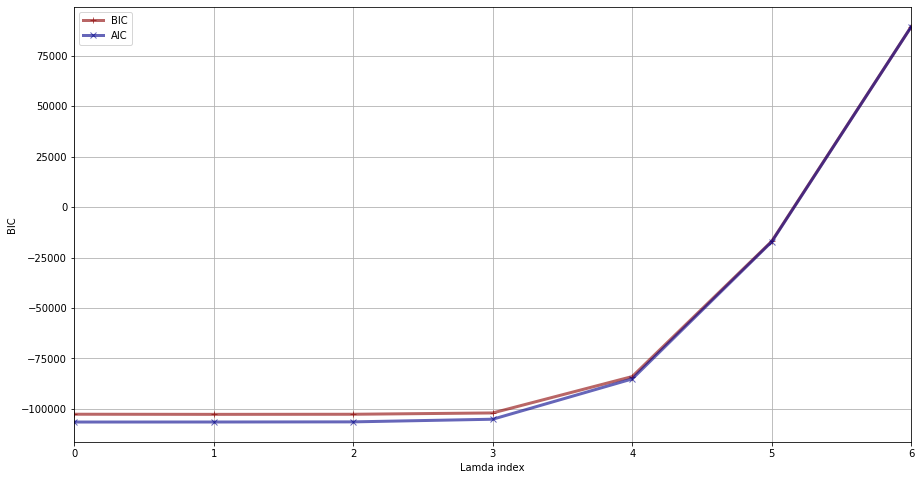

In [400]:
plt.figure(figsize=(15, 8))
#plt.plot(train_bic, 'bo-', label=r'BIC Training set', color="darkblue", alpha=0.6, linewidth=3, marker ='x')
#plt.plot(test_bic, 'bo-', label=r'BIC Test set', color="darkred", alpha=0.6, linewidth=3, marker ='+')
plt.plot(bic, 'bo-', label=r'BIC', color="darkred", alpha=0.6, linewidth=3, marker ='+')
plt.plot(aic, 'bo-', label=r'AIC', color="darkblue", alpha=0.6, linewidth=3, marker ='x')
plt.xlabel('Lamda index'); plt.ylabel(r'BIC')
plt.xlim(0, 6)
#plt.title(r'Evaluate lasso regression with lamdas: 0 = 0, 1= 0.01, 2 = 0.1, 3 = 0.2, 4= 0.5, 5= 1, 6 = 2')
plt.legend(loc='best')
plt.grid()

Text(0.5, 1.0, 'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.2, 4= 0.5, 5= 1, 6 = 2')

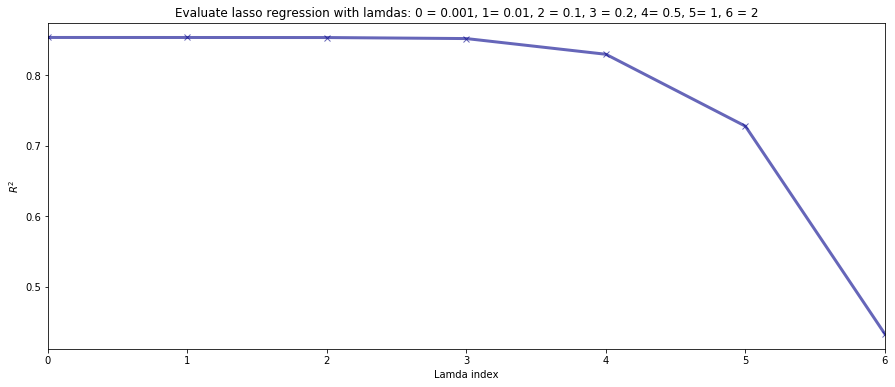

In [401]:
# Plotting
plt.figure(figsize=(15, 6))
#plt.plot(train_aic, 'bo-', label=r'AIC Training set', color="darkblue", alpha=0.6, linewidth=3, marker ='x')
#plt.plot(test_aic, 'bo-', label=r'AIC Test set', color="darkred", alpha=0.6, linewidth=3, marker ='+')
plt.plot(r_squared, 'bo-', label=r'$R^2$', color="darkblue", alpha=0.6, linewidth=3, marker ='x')
#plt.plot(bic, 'bo-', label=r'BIC', color="darkred", alpha=0.6, linewidth=3, marker ='+')
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.2, 4= 0.5, 5= 1, 6 = 2')
#plt.legend(loc='best')

#plt.savefig('lasso_r_squared_cv.pdf',transparent=True)

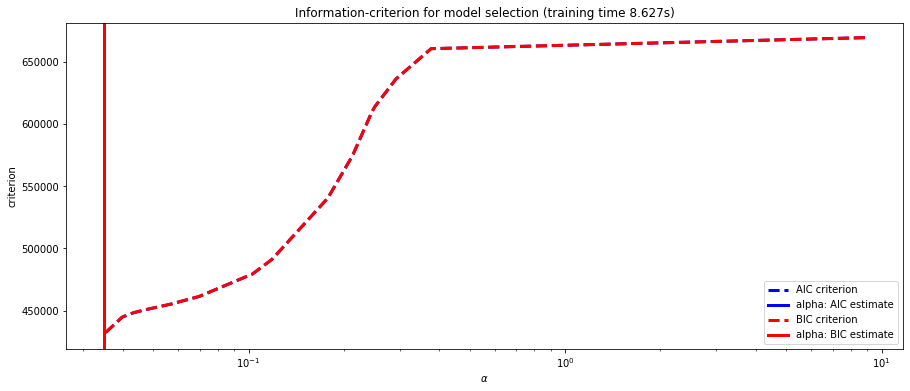

In [356]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import time
EPSILON = 1e-4
model_bic = LassoLarsIC(criterion='bic', normalize=False, max_iter=15)
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic', normalize=False, max_iter=15)
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')


plt.figure(figsize=(15, 6))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)
plt.savefig('lasso_aic_bic_cv.pdf',transparent=True)

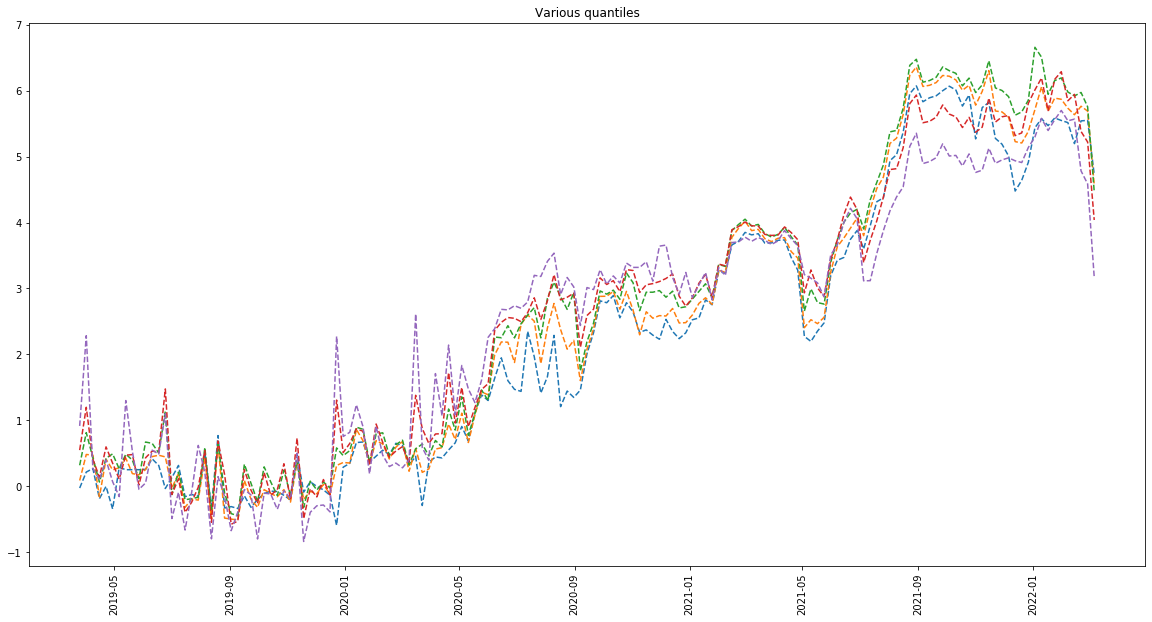

In [15]:

from mlinsights.mlmodel import QuantileLinearRegression

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
clqs = {}
for qu in quantiles:
    clq = QuantileLinearRegression(quantile=qu)
    clq.fit(X, y)
    clqs['q=%1.2f' % qu] = clq

import matplotlib.dates as mdates
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for qu in sorted(clqs):
    beta = clqs[qu].coef_[109:264]
    ax.plot(xx, beta, "--", label=qu)

plt.xticks(rotation = 90)
mafmt = mdates.DateFormatter("%Y")
ax.set_title("Various quantiles");

plt.savefig('quantile_reg_beta.pdf',transparent=True)